# Introduction to Deep Learning - Week4

Peer-graded Assignment: NLP Disaster Tweets Kaggle Mini-Project

## 0. Introduction

This notebook is for the assignment of the course Introduction in Deep Learning : Week 4 NLP Disaster Tweets Kaggle Mini-Project. The assignment is to apply the NLP algorithms on real data. The mini project is hosted on Kaggle ("https://www.kaggle.com/competitions/nlp-getting-started"). The method is used for predicting which Tweets are about real disasters and which one’s aren’t.

## 1 EDA

### 1.1 Data input

In [1]:
# Ensure compatibility of moduels
!pip install numpy==1.21.6
!pip install transformers

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

print("TensorFlow version:", tf.__version__)
print("Transformers version:", tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 50.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.81 requires numpy>=1.25.0, but you have numpy 1.21.6 which is incompatible.
cudf 23.6.1 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.20.3 which is incompati

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

TensorFlow version: 2.12.0
Transformers version: 2.12.0


Load the datasets from the working directory

In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


Check and drop possible NAs 

In [3]:
# Drop rows without logged text 
df_train.dropna(subset=['text'], inplace=True)
df_test.dropna(subset=['text'], inplace=True)

# Check missing values
print(df_train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


The text is used for predicting, so the missing values in the keyword and location columns are ignored

## 1.2 Exploration

First, let us check the dataset sizes.

In [4]:
print(f"Training Set Shape: {df_train.shape}")
print(f"Training Set Memory Usage: {df_train.memory_usage().sum() / 1024**2:.2f} MB")
print(f"Test Set Shape: {df_test.shape}")
print(f"Test Set Memory Usage: {df_test.memory_usage().sum() / 1024**2:.2f} MB")

Training Set Shape: (7613, 5)
Training Set Memory Usage: 0.29 MB
Test Set Shape: (3263, 4)
Test Set Memory Usage: 0.10 MB


Take a look at the data. The effective information is the IDs, texts, and labels.

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let us check some random tweets. There are obvious negative words in disaster tweets.

In [7]:
# View random disaster tweets
print("Examples of Disaster Tweets:")
print(df_train[df_train['target']==1]['text'].sample(5).values)
print()

# View random non-disaster tweets
print("Examples of Non-Disaster Tweets:")
print(df_train[df_train['target']==0]['text'].sample(5).values)


Examples of Disaster Tweets:
["#OMG! I don't believe this. #RIP bro\n#AirPlane #Accident #JetEngine #TurboJet #Boing #G90 http://t.co/KXxnSZp6nk"
 'Meet Brinco your own personal earthquake snd tsunami early warning beacon. http://t.co/NXkUM9h7wD'
 'The date for the release of EP03 DESOLATION is set. Stay tuned for more info while we finalise the schedule. #alt #electro #rock #comingsoon'
 'Does homeowners insurance cover water damage? Here are some good things to know. http://t.co/0uSDI5JCHo http://t.co/xyg7JhRjoF'
 'Property losses from #California wildfire nearly double as week-old blaze rages: The fire\x89Û_ http://t.co/MsdizftZ2g']

Examples of Non-Disaster Tweets:
['Fear has a way of making us see danger where there is none. Contemplating the logic behind the situation and find the courage to engage it'
 'Ablaze for you Lord :D'
 '@kakajambori ??\nU control the future of india..\nYor Subject: Exploration or seismic Maintenance( Electrical or Mechanical)'
 "My lifelong all-time fav

The next step is to check if the train and test datasets are balanced. First, let us check the categories.

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


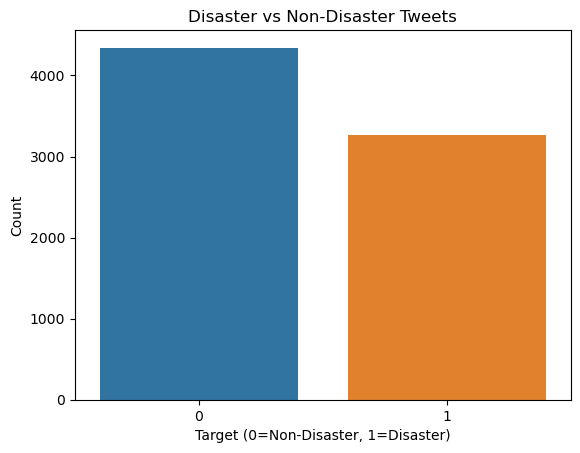

0    57.034021
1    42.965979
Name: target, dtype: float64


In [8]:
# Check missing values
print(df_train.isnull().sum())

# Check target class distribution
sns.countplot(x='target', data=df_train)
plt.title('Disaster vs Non-Disaster Tweets')
plt.xlabel('Target (0=Non-Disaster, 1=Disaster)')
plt.ylabel('Count')
plt.show()

# Also percentage
print(df_train['target'].value_counts(normalize=True) * 100)


Then, let us check the distributions of texts.

In [9]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


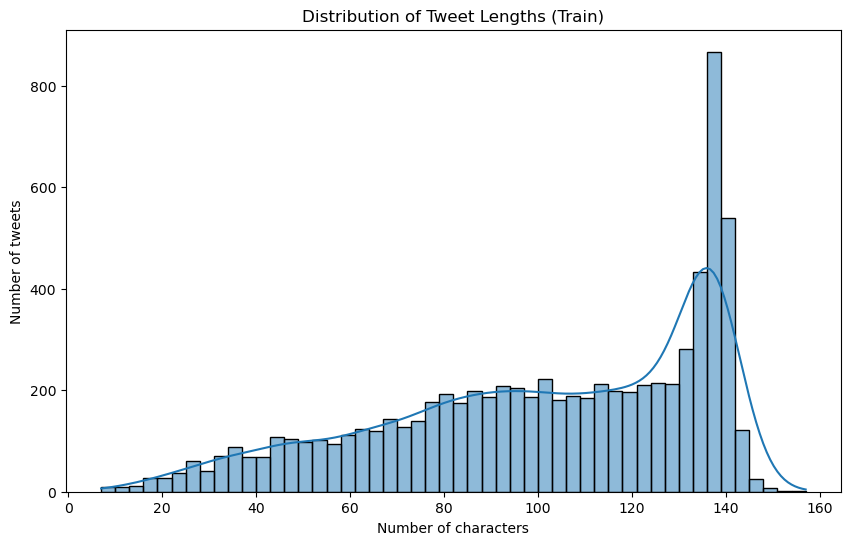

In [10]:
# Plot histogram of tweet lengths
plt.figure(figsize=(10,6))
sns.histplot(df_train['length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths (Train)')
plt.xlabel('Number of characters')
plt.ylabel('Number of tweets')
plt.show()


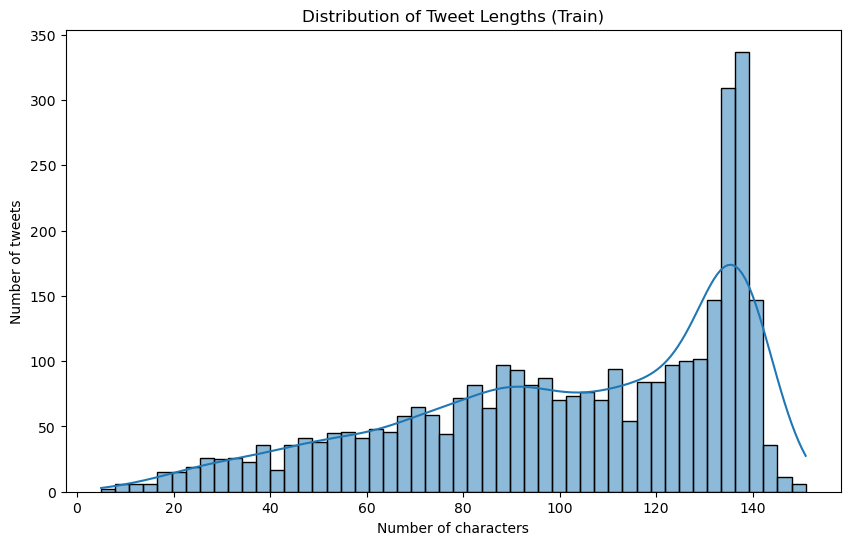

In [11]:
# Plot histogram of tweet lengths
plt.figure(figsize=(10,6))
sns.histplot(df_test['length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths (Train)')
plt.xlabel('Number of characters')
plt.ylabel('Number of tweets')
plt.show()

It shows the distributions of two text length are close. In the following, let us take a look of the common words.

The most common words of the two datasets are relatively the same. Let us build a word cloud.

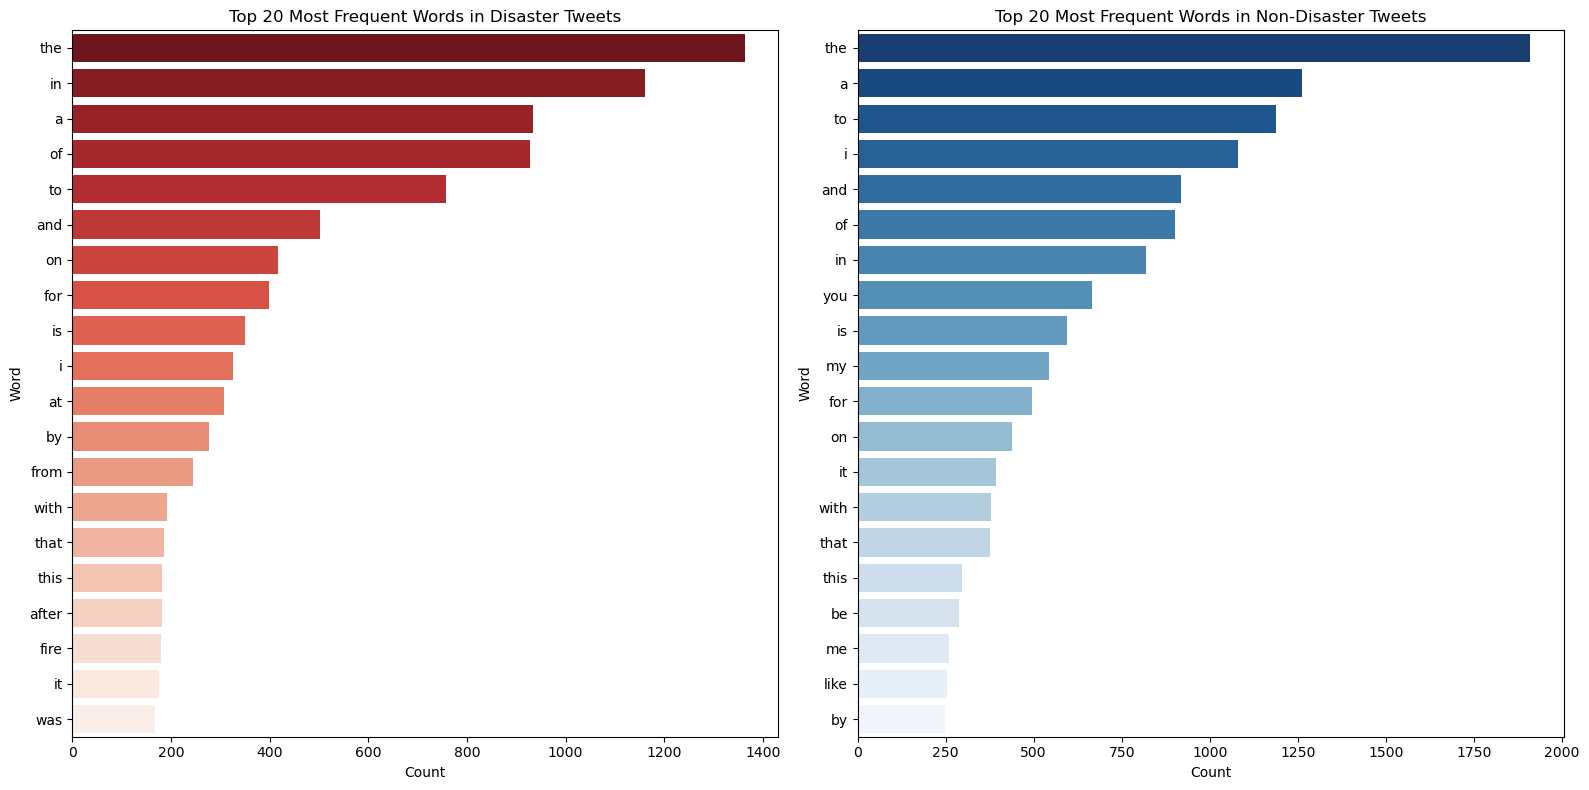

In [13]:
from collections import Counter
import re

# Disaster tweets
disaster_words = " ".join(df_train[df_train['target']==1]['text']).lower()
disaster_words = re.sub(r"[^a-z\s]", "", disaster_words)
disaster_word_list = disaster_words.split()
disaster_word_counts = Counter(disaster_word_list)
top_disaster = disaster_word_counts.most_common(20)
disaster_word_freq_df = pd.DataFrame(top_disaster, columns=['word', 'count'])

# Non-Disaster tweets
non_disaster_words = " ".join(df_train[df_train['target']==0]['text']).lower()
non_disaster_words = re.sub(r"[^a-z\s]", "", non_disaster_words)
non_disaster_word_list = non_disaster_words.split()
non_disaster_word_counts = Counter(non_disaster_word_list)
top_non_disaster = non_disaster_word_counts.most_common(20)
non_disaster_word_freq_df = pd.DataFrame(top_non_disaster, columns=['word', 'count'])

# Plot side by side
plt.figure(figsize=(16,8))

# Plot for disaster
plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=disaster_word_freq_df, palette='Reds_r')
plt.title('Top 20 Most Frequent Words in Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Word')

# Plot for non-disaster
plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=non_disaster_word_freq_df, palette='Blues_r')
plt.title('Top 20 Most Frequent Words in Non-Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Word')

plt.tight_layout()
plt.show()


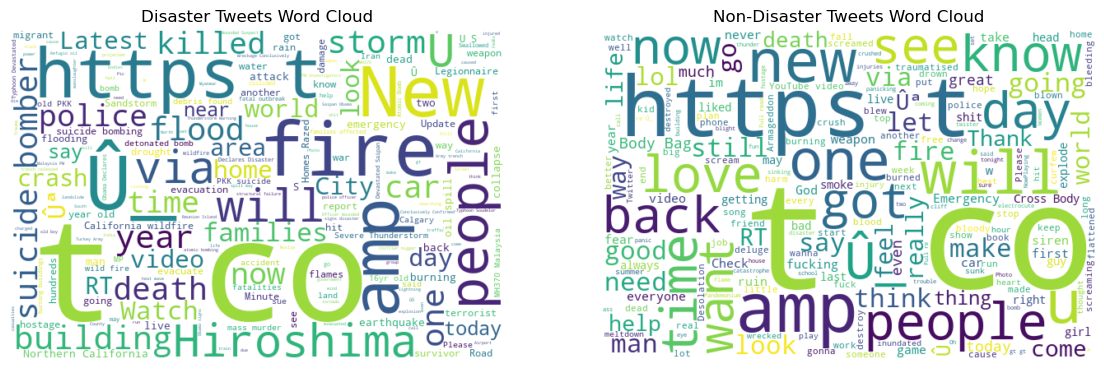

In [14]:
!pip install wordcloud
from wordcloud import WordCloud

# Separate disaster and non-disaster tweets
disaster_tweets = df_train[df_train['target']==1]['text']
non_disaster_tweets = df_train[df_train['target']==0]['text']

# Generate word clouds
disaster_text = ' '.join(disaster_tweets)
non_disaster_text = ' '.join(non_disaster_tweets)

plt.figure(figsize=(14,6))

# Disaster tweets wordcloud
plt.subplot(1,2,1)
wordcloud1 = WordCloud(width=600, height=400, background_color='white').generate(disaster_text)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('Disaster Tweets Word Cloud')

# Non-disaster tweets wordcloud
plt.subplot(1,2,2)
wordcloud2 = WordCloud(width=600, height=400, background_color='white').generate(non_disaster_text)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Disaster Tweets Word Cloud')

plt.show()

Through obervations, I summarize the negative words in the disaster set. Let us find out their frequencies in the two datasets.

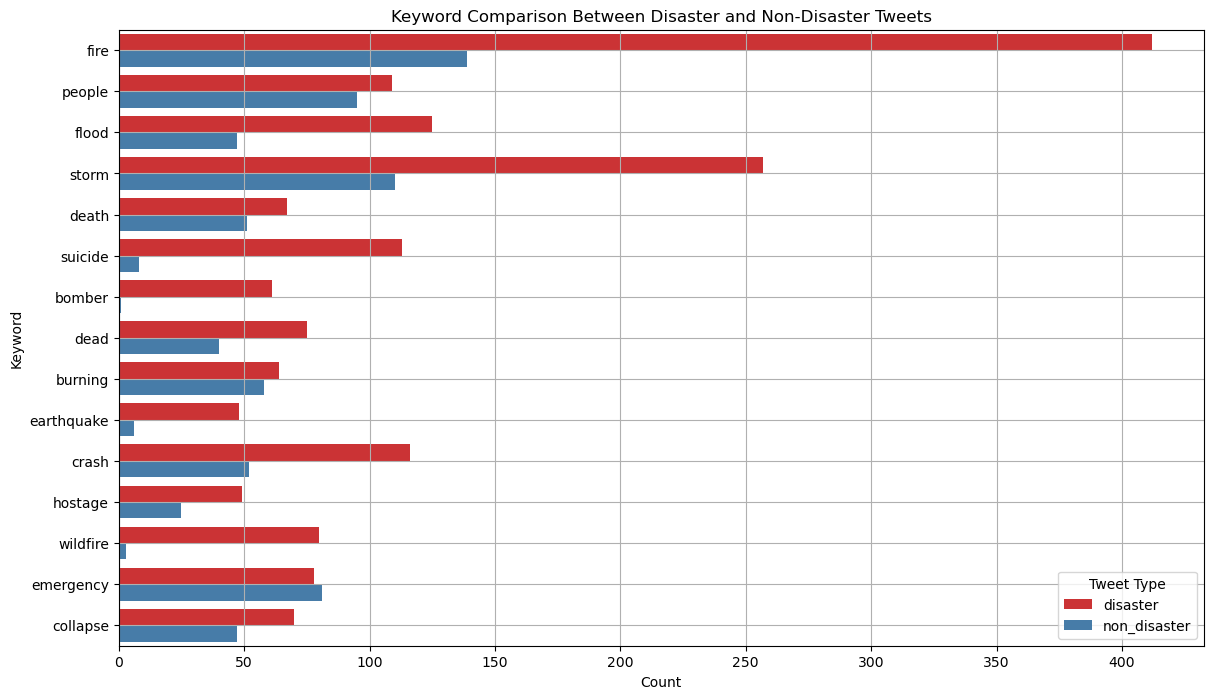

In [15]:
# List of important keywords you want to track
keywords = ['fire', 'people', 'flood', 'storm', 'death', 'suicide', 'bomber', 
            'dead', 'burning', 'earthquake', 'crash', 'hostage', 'wildfire', 'emergency', 'collapse']

# Prepare lowercased text for each category
disaster_words = " ".join(df_train[df_train['target']==1]['text']).lower()
non_disaster_words = " ".join(df_train[df_train['target']==0]['text']).lower()

# Count occurrences for each keyword
disaster_keyword_counts = {}
non_disaster_keyword_counts = {}

for keyword in keywords:
    disaster_keyword_counts[keyword] = disaster_words.count(keyword)
    non_disaster_keyword_counts[keyword] = non_disaster_words.count(keyword)

# Convert to DataFrame for easy plotting
keyword_freq_df = pd.DataFrame({
    'keyword': keywords,
    'disaster': [disaster_keyword_counts[k] for k in keywords],
    'non_disaster': [non_disaster_keyword_counts[k] for k in keywords]
})

# Melt DataFrame to long format for Seaborn
keyword_freq_melted = keyword_freq_df.melt(id_vars='keyword', 
                                           value_vars=['disaster', 'non_disaster'],
                                           var_name='category', 
                                           value_name='count')

# Plot
plt.figure(figsize=(14,8))
sns.barplot(x='count', y='keyword', hue='category', data=keyword_freq_melted, palette='Set1')
plt.title('Keyword Comparison Between Disaster and Non-Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.legend(title='Tweet Type')
plt.grid(True)
plt.show()


The result shows negative words are more frequently exist in the disaster set. Especially, the word "bomber" would highly indicate disasters.

### 1.3 EDA summary

From the EDA, two conclusions are made:

(1) The train and test data sets are balanced.

(2) There exists differences between the diaster and non-disaster tweets.

## 2. Model Building and Training

In the project, DistilBERT (distilbert-base-uncased) is applied. Only the text information was used for predictions.

### 2.1 Model building

In [16]:
# Tokenization
pretrained_model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name)

In [17]:
# Encode the dataset
train_encodings = tokenizer(list(df_train['text'].values), truncation=True, padding=True, max_length=160)
test_encodings = tokenizer(list(df_test['text'].values), truncation=True, padding=True, max_length=160)

In [18]:
# Prepare TensorFlow datasets
X_input_ids = np.array(train_encodings['input_ids'])
X_attention_mask = np.array(train_encodings['attention_mask'])
y = np.array(df_train['target'].values)

X_train_ids, X_val_ids, y_train, y_val = train_test_split(X_input_ids, y, test_size=0.2, random_state=42)
X_train_mask, X_val_mask, _, _ = train_test_split(X_attention_mask, y, test_size=0.2, random_state=42)

In [19]:
# Build Model
model = TFDistilBertForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [20]:
# Compile Model
optimizer = keras.optimizers.Adam(learning_rate=5e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

###  2.2 Model training

In [22]:
# from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, restore_best_weights=True)

history = model.fit(
    {'input_ids': X_train_ids, 'attention_mask': X_train_mask},
    y_train,
    batch_size=16,
    epochs=6,  # allow more epochs under early stopping
    validation_data=(
        {'input_ids': X_val_ids, 'attention_mask': X_val_mask},
        y_val
    ),
    callbacks=[early_stopping]
)

Epoch 1/6
381/381 [==============================] - 80s 147ms/step - loss: 0.4488 - accuracy: 0.8041 - val_loss: 0.4003 - val_accuracy: 0.8280
Epoch 2/6
381/381 [==============================] - 40s 106ms/step - loss: 0.3018 - accuracy: 0.8783 - val_loss: 0.4252 - val_accuracy: 0.8181


### 2.3 Evaluation

First, let us check the accuracies.

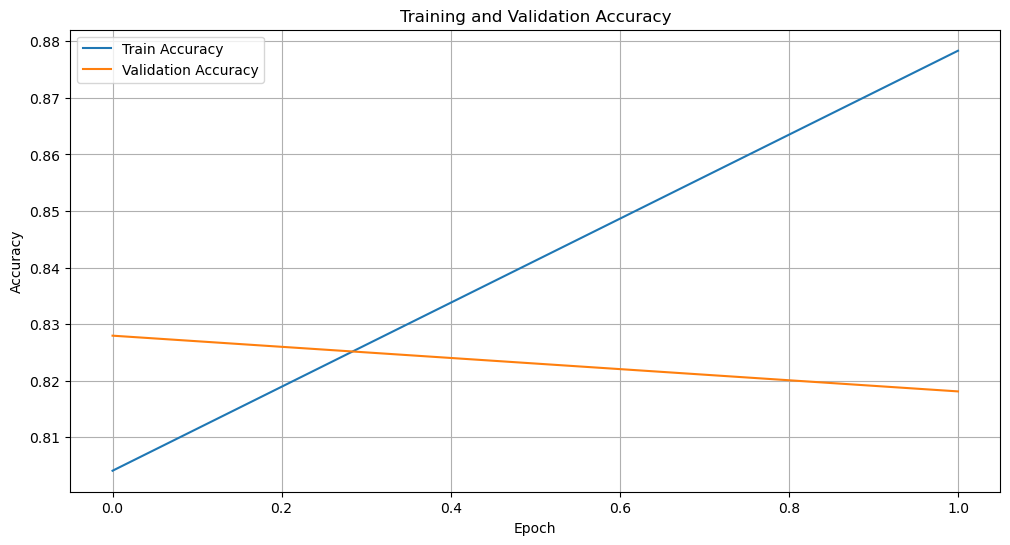

In [23]:
# Plot Training History
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

The training is controlled by the early stopping. The final validation accuracy is roughly 0.82. Now let us visualize the evaluations by ploting the confusion matrix, AUC, and RUC.

48/48 [==============================] - 4s 61ms/step


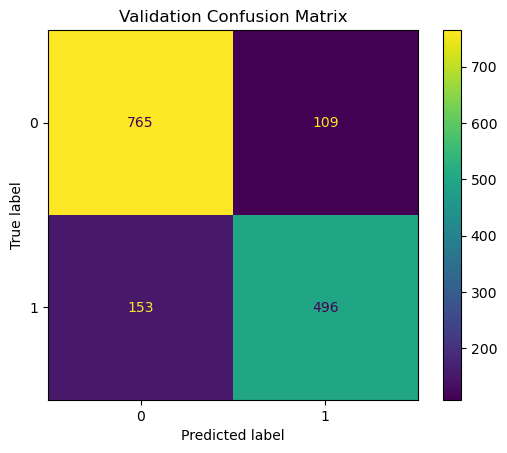

In [26]:
# Generate predictions
y_pred_logits = model.predict({'input_ids': X_val_ids, 'attention_mask': X_val_mask}).logits
y_pred = np.argmax(y_pred_logits, axis=1)  # Convert logits to predicted class (0 or 1)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title('Validation Confusion Matrix')
plt.show()

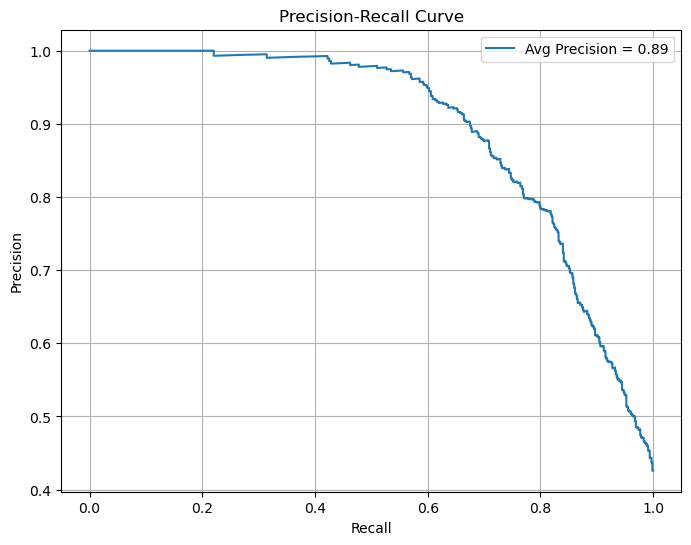

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for class 1 (disaster)
y_pred_probs = tf.nn.softmax(y_pred_logits).numpy()[:,1]

precision, recall, thresholds = precision_recall_curve(y_val, y_pred_probs)
avg_precision = average_precision_score(y_val, y_pred_probs)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

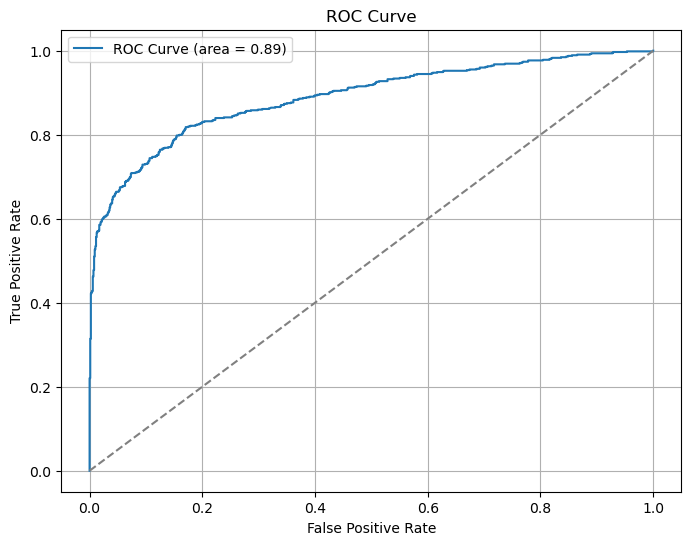

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


These visualizations show a relative good fit.

# 3. Conclusion

In this mini-project, pure tweet texts are used to predict whether a tweet discribes a real disaster. The model gives a relatively good fit. Futher work  could be included more information, such as keywords and locations.

# 4. Submission

Let us output a csv file for submission

In [29]:
# Prepare test inputs
test_input_ids = np.array(test_encodings['input_ids'])
test_attention_mask = np.array(test_encodings['attention_mask'])

# Predict on test set
test_pred_logits = model.predict(
    {'input_ids': test_input_ids, 'attention_mask': test_attention_mask},
    batch_size=16,  # You can adjust this depending on memory
    verbose=1
).logits

# Convert logits to class predictions
test_pred = np.argmax(test_pred_logits, axis=1)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': df_test['id'],
    'target': test_pred
})

# Save to CSV
submission.to_csv('/kaggle/working/submission.csv', index=False)

204/204 [==============================] - 8s 32ms/step


In [30]:
print("Files in working directory:", os.listdir('/kaggle/working'))  # show working directory
print(os.listdir())  # Check if 'submission.csv' is actually saved

Files in working directory: ['.virtual_documents', 'submission.csv']
['.virtual_documents', 'submission.csv']


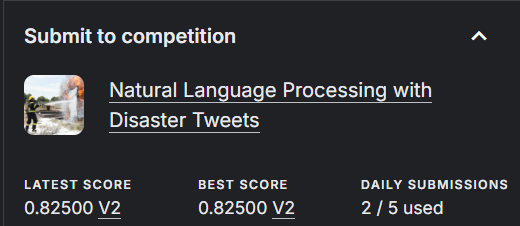